In [1]:

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

import pandas as pd
import os

# Encontra diretorio atual
atual_dir = os.getcwd()

# Acessa arquivo pkl das noticias
parent_dir = os.path.split(atual_dir)

parent_dir = os.path.split(parent_dir[0])

parent_dir = os.path.split(parent_dir[0])

caminho_pkl = os.path.join(parent_dir[0], "Pre-processamento\\noticias_pre_processadas_df.pkl")

# Carregar dataframe salvo em formato pickle
df = pd.read_pickle(caminho_pkl)


In [2]:
df.head()

,Texto,label
0,"[poder, decidir, expulsar, deputado, federal, ...",1
1,"[bolsonaro, liberal, completo, presidente, psl...",1
2,"[ministro, stf, liberar, Andrea, Neves, prisao...",1
3,"[apesar, abundancia, crescer, preocupacao, pre...",1
4,"[harvard, mit, levarao, dilma, moro, suplicy, ...",1


In [3]:
# Converte a coluna 'Texto' do DataFrame em uma lista e armazena na variável texts. O mesmo com as labels
texts = df['Texto'].tolist()
labels = df['label'].tolist()  

In [4]:
# Tokenização
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# word_index é um dicionário onde as chaves são as palavras e os valores são os índices dessas palavras.
# Esse índice é útil para várias tarefas de NLP, como a criação de embeddings de palavras ou a preparação de dados para modelos de deep learning.
word_index = tokenizer.word_index

In [5]:
import pickle

# Salva o tokenizador em um arquivo (precisamos dele mais tarde, quando realizarmos as inferências)
with open('tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)

In [6]:
import numpy as np

# Calcula o comprimento de cada sequência em 'sequences' e armazena os resultados na lista 'sequence_lengths'
sequence_lengths = [len(seq) for seq in sequences]

# Calcula a média dos comprimentos das sequências usando a função 'mean' do numpy
mean_length = np.mean(sequence_lengths)

# Obtém o comprimento máximo das sequências usando a função 'max' do Python
max_length = max(sequence_lengths)

# Imprime a média e o comprimento máximo das sequências
print("Mean sequence length: ", mean_length)
print("Maximum sequence length: ", max_length)

Mean sequence length:  173.9763956201759
Maximum sequence length:  3835


In [7]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Calcula o percentil 95 dos comprimentos das sequências (preserva 95% das sequências)
max_length = int(np.percentile(sequence_lengths, 95))

# Realiza o preenchimento das sequências com base no novo 'max_length'
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

In [8]:
# Carrega os embeddings do GLoVe
embeddings_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [9]:
# Preparar a matriz de embedding
embedding_dim = 100  # o tamanho do GLoVe embeddings (100)
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [10]:
# One-hot encoding dos labels
num_classes = len(np.unique(labels))  # Número de classes únicas
labels = to_categorical(labels, num_classes=num_classes)

In [11]:
from sklearn.model_selection import train_test_split

# Divide os dados em um conjunto de treino (70%) e um conjunto temporário (30%)
X_train, X_temp, y_train, y_temp = train_test_split(padded_sequences, labels, test_size=0.3)

# Divide o conjunto temporário em conjuntos de validação (15%) e teste (15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)  

In [12]:
# Construindo o modelo
model = Sequential()  # Inicialização de um modelo sequencial
model.add(Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix], trainable=False))  # Adicionando camada de incorporação com pesos pré-treinados e não treináveis
model.add(Bidirectional(LSTM(64, return_sequences=True)))  # Adicionando camada LSTM bidirecional com retorno de sequências
model.add(Bidirectional(LSTM(32)))  # Adicionando outra camada LSTM bidirecional
model.add(Dense(num_classes, activation='softmax'))  # Adicionando camada densa de saída para classificação multiclasse com ativação softmax

# Chamada ao Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)  # Configuração do Early Stopping para monitoramento da perda de validação e paciência 5

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  # Compilação do modelo com função de perda, otimizador e métricas

# Treinamento do modelo
history = model.fit(X_train, y_train, batch_size=128, epochs=40, validation_data=(X_val, y_val), callbacks=[early_stopping])  # Treinamento do modelo com os dados de treinamento, validação e chamada ao Early Stopping


Epoch 1/40
122/122 [==============================] - 56s 339ms/step - loss: 0.5345 - accuracy: 0.7462 - val_loss: 0.4664 - val_accuracy: 0.8109
Epoch 2/40
122/122 [==============================] - 40s 328ms/step - loss: 0.3882 - accuracy: 0.8356 - val_loss: 0.2949 - val_accuracy: 0.8890
Epoch 3/40
122/122 [==============================] - 41s 332ms/step - loss: 0.2785 - accuracy: 0.8952 - val_loss: 0.2727 - val_accuracy: 0.8947
Epoch 4/40
122/122 [==============================] - 41s 333ms/step - loss: 0.2419 - accuracy: 0.9113 - val_loss: 0.2324 - val_accuracy: 0.9097
Epoch 5/40
122/122 [==============================] - 41s 333ms/step - loss: 0.2120 - accuracy: 0.9226 - val_loss: 0.2202 - val_accuracy: 0.9165
Epoch 6/40
122/122 [==============================] - 41s 335ms/step - loss: 0.2047 - accuracy: 0.9218 - val_loss: 0.2135 - val_accuracy: 0.9192
Epoch 7/40
122/122 [==============================] - 41s 335ms/step - loss: 0.1827 - accuracy: 0.9325 - val_loss: 0.2173 - val_ac

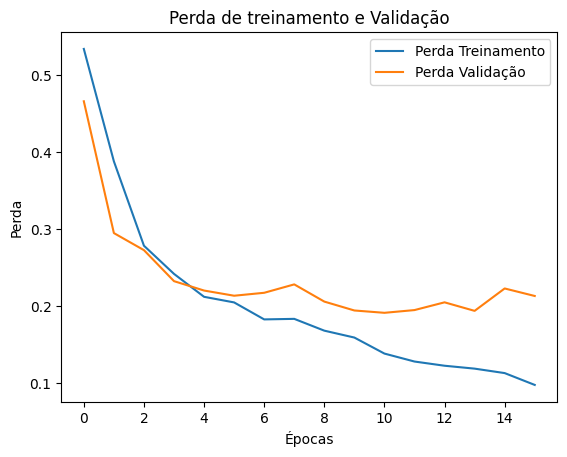

In [13]:
import matplotlib.pyplot as plt

# Plota a perda (loss) e a perda de validação (val_loss) durante o treinamento
plt.plot(history.history['loss'], label='Perda Treinamento')
plt.plot(history.history['val_loss'], label='Perda Validação')
plt.title('Perda de treinamento e Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.show()

In [14]:
# Salva arquivos em discos que podemos carregar sem treinar a rede neural novamente
model.save('modelo_BiLSTM_glove6b100d.h5')
np.save("X_test_BiLSTM_glove6b100d.npy", X_test)
np.save("y_test_BiLSTM_glove6b100d.npy", y_test)

In [15]:
loss, accuracy = model.evaluate(X_test, y_test)
print('Acurácia final:', accuracy)

105/105 [==============================] - 11s 106ms/step - loss: 0.1930 - accuracy: 0.9330
Acurácia final: 0.9329943060874939


In [16]:
# Fazer as previsões do modelo para o conjunto de teste
y_pred = model.predict(X_test)

105/105 [==============================] - 13s 110ms/step


In [17]:
#Transformar as previsões de volta em rótulos
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Calcular a matriz de confusão
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_true_labels, y_pred_labels)

conf_mat

array([[1618,   89],
       [ 135, 1501]], dtype=int64)

In [18]:
import pandas as pd
import os

# Encontra diretorio atual
atual_dir = os.getcwd()

# Acessa arquivo pkl das noticias
parent_dir = os.path.split(atual_dir)

parent_dir = os.path.split(parent_dir[0])

parent_dir = os.path.split(parent_dir[0])

caminho_pkl = os.path.join(parent_dir[0], "Pre-processamento\\noticias_pre_processadas_df.pkl")

# Carregar dataframe salvo em formato pickle
df = pd.read_pickle(caminho_pkl)

# Total de classes
classes = df['label'].nunique()

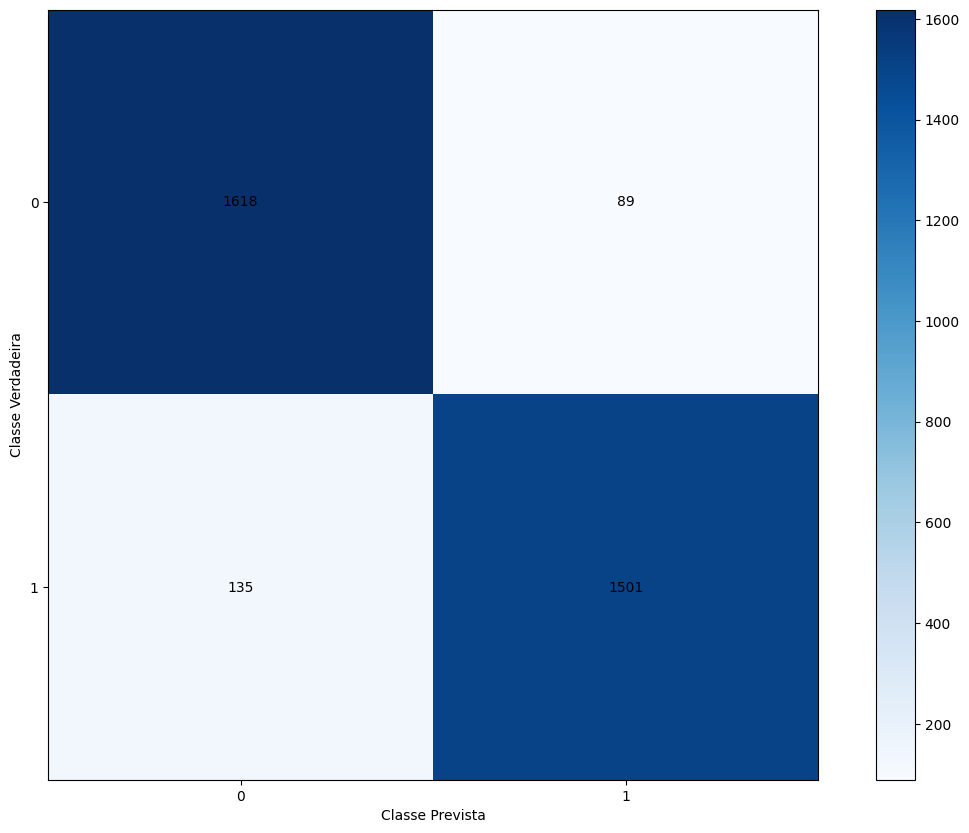

In [19]:
import matplotlib.pyplot as plt

# Define o tamanho da figura
plt.figure(figsize=(15, 10))

# Define mapa de cores
cmap = plt.cm.Blues

# Plota matriz de confusão
plt.imshow(conf_mat, cmap=cmap)
plt.colorbar()

# Adiciona labels a matriz
plt.xticks([int(i) for i in range(2)], [str(i) for i in range(2)])
plt.yticks([int(i) for i in range(2)], [str(i) for i in range(2)])

for i in range(classes):
    for j in range(classes):
        plt.text(j, i, str(conf_mat[i, j]), ha='center', va='center', color='white' if conf_mat[i, j] > len(y_true_labels)/ classes else 'black')

# Adiciona rótulos dos eixos
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Verdadeira')

# Mostra o plot
plt.show()

In [20]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Calcula precisão, recall e f1-score para cada classe
precisions = []
recalls = []
f1_scores = []
for i in range(classes):
    precision = precision_score(y_true=y_true_labels == i, y_pred=y_pred_labels == i, zero_division=0)
    recall = recall_score(y_true=y_true_labels == i, y_pred=y_pred_labels == i, zero_division=0)
    f1 = f1_score(y_true=y_true_labels == i, y_pred=y_pred_labels == i, zero_division=0)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    
# Printa resultados
for i in range(classes):
    print(f"Classe '{i}': Precisão={precisions[i]:.4f}, Recall={recalls[i]:.4f}, F1-Score={f1_scores[i]:.4f}")

# Calcula e printa a média dos f1-scores
f1_average = np.mean(f1_scores)
print(f"F1-Score médio: {f1_average:.4f}")

Classe '0': Precisão=0.9230, Recall=0.9479, F1-Score=0.9353
Classe '1': Precisão=0.9440, Recall=0.9175, F1-Score=0.9306
F1-Score médio: 0.9329
